In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#import required package
from __future__ import division
from scipy import interpolate
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import spectral.io.envi as envi
from spectral import *
import os
import re
import math
import PIL
from scipy import signal
from scipy import ndimage
from scipy import spatial
from scipy import stats
from scipy import interpolate
import traceback
import sys
import pickle
import warnings
from pprint import pprint
from osgeo import gdal

In [3]:
#file mangement generates a list containing a pth to all hdr files of pre-processed observations
def get_all_processed_HDR_addresses():
    parentDirectory="G:/0000A546/"
    observationDirectories=[]
    for (_,temporaryList,_) in os.walk(parentDirectory):
        observationDirectories.extend(temporaryList)
        break

    hdrPattern=".hdr$"
    ObservationImageAddresses=[]


    for j in observationDirectories:
        currentDirectory=parentDirectory+'/'+j
        observationFiles=[]
        for (_,_,temporaryList) in os.walk(currentDirectory):
            observationFiles.extend(temporaryList)
            break

        for i in observationFiles:
            if re.search(hdrPattern,i):
                ObservationImageAddresses.append(currentDirectory+"/"+i[:i.index(".hdr")]+"_corr_p.hdr")
    return ObservationImageAddresses

In [4]:
#read hrd files for wavlengths of all bands
def read_CRISM_Image_wavelengths(headerFileAddress):
    wavelengthFile="J:/IIT/user/Documents/CRISM Multispectral Exploration/Processed_observations/wavelength_list.txt"
    
    currentObservationHeader=envi.open(headerFileAddress)
    currentObservationImage=currentObservationHeader.open_memmap()
    currentObservationArray=np.array(currentObservationImage)
    #currentObservationArray=spectral.open_image(i)

    #read wavelengths from saved wavelength file
    with open (wavelengthFile, 'rb') as fp:
        wavelengthsOfCurrentObservation=pickle.load(fp)
    return currentObservationArray,wavelengthsOfCurrentObservation

In [5]:
#find index of wavelngth closest to given wavelength
def find_nearest(wavelength_list,value): #find wavelength value in list closest to given value
    idx = np.searchsorted(wavelength_list, value, side="left")
    if idx > 0 and (idx == len(wavelength_list) or math.fabs(value - wavelength_list[idx-1]) < math.fabs(value - wavelength_list[idx])):
        return wavelength_list[idx-1]
    else:
        return wavelength_list[idx]

def find_wavelength_index(wavelength_list,item): #return index of in the array
    first = 0
    last = len(wavelength_list)-1
    found = False
    while( first<=last and not found):
        mid = (first + last)//2
        if wavelength_list[mid] == item :
            found = True
        else:
            if item < wavelength_list[mid]:
                last = mid - 1
            else:
                first = mid + 1	
    return mid
def find_nearest_index(wavelength_list,wavelength): #get wavelength in index closest to gicen wavelength and return its index
    (nearest_index,nearest_wavelength)=min(enumerate(wavelength_list), key=lambda x: abs(x[1]-wavelength))
    return nearest_index
def find_nearest_index_for_list(wavelength_list,wavelengths): # find index of nearest value for a list of given values
    indices=[]
    for i in wavelengths:
        indices.append(find_nearest_index(wavelength_list,i))
    return indices

In [6]:
# given a hyperspectral datacube and wavelengths to serve as upper and lower thresholds subset the datacube along the spectral direction
def get_spectral_subset(datacube,wavelength_list,lower_threshold,upper_threshold): #returns spectral subset from lower to upper threshold ( 1.2 to 2.6 micrometer for CRISM IR)
    lower_threshold_index=find_wavelength_index(wavelength_list,lower_threshold)
    upper_threshold_index=find_wavelength_index(wavelength_list,upper_threshold)
    thresholdedDatacube=datacube[:,:,lower_threshold_index:upper_threshold_index+1]
    thresholdedWavelengthList=wavelength_list[lower_threshold_index:upper_threshold_index+1]
    return thresholdedDatacube,thresholdedWavelengthList

In [7]:
# threshold image at 2.6 micrometer
def preProcessImage(imageHeaderAddress): # given address of a CRISM header file, read the data, deal with NaN values and apply spectral subset
    datacube,wavelength_list=read_CRISM_Image_wavelengths(imageHeaderAddress) #read image and wavelength_list
    datacube=np.where(np.logical_and(datacube>0,datacube<1),datacube,0)
    lower_threshold_for_spectral_subset=1.0
    upper_threshold_for_spectral_subset=2.59 #define wavelength threshold (CRISM data too noisy post 2.6 micrometer)
    datacube,wavelength_list=get_spectral_subset(datacube,wavelength_list,lower_threshold_for_spectral_subset,upper_threshold_for_spectral_subset)
    return datacube,wavelength_list

In [8]:
#given a datacube return its footprint i.e pixels in and out of the scene
def getDatacubeFootprint(datacube):
    [row,col,bands]=np.shape(datacube)
    #create an array to hold footprint of the image
    footprint=np.zeros_like(datacube[:,:,0])
    #get foot print of in scene pixels
    for i in range(row):
        for j in range(col):
            if 0==datacube[i,j,:].all():
                footprint[i,j]=1
    return footprint

In [9]:
#given a spectra normalize it to the range (0,1)
def normalizeSpectra(spectra):
    return (spectra - np.min(spectra))/np.ptp(spectra)

In [10]:
#given a datacube normalize all spectra
def normalizeDatacube(datacube):
    #get dimensions
    [row,col,bands]=datacube.shape
    #iterate through pixels
    for i in range(row):
        for j in range(col):
            datacube[i,j,:]=normalizeSpectra(datacube[i,j,:])
    return datacube

In [91]:
'''#create a 3X3X3 structuring element
structingElementSize=5
structuringElement=np.full((structingElementSize,structingElementSize,structingElementSize), 1.0/structingElementSize**3)
#apply mean filter to the datacube using the structuring element
filteredDatacube=ndimage.filters.convolve(despikedDatacube,structuringElement,output=None,mode='reflect')'''

"#create a 3X3X3 structuring element\nstructingElementSize=5\nstructuringElement=np.full((structingElementSize,structingElementSize,structingElementSize), 1.0/structingElementSize**3)\n#apply mean filter to the datacube using the structuring element\nfilteredDatacube=ndimage.filters.convolve(despikedDatacube,structuringElement,output=None,mode='reflect')"

In [86]:
#set directory where files are to be saved
processedImageDirectory="G:/00019538"
#set the address of the file to be denoised
headerFileAddress="G:/00019538/frt00019538_07_if166l_trr3_CAT_corr.hdr"
#open the img file
currentObservationHeader=envi.open(headerFileAddress)
currentObservationImage=currentObservationHeader.open_memmap()
datacube=np.array(currentObservationImage)
del currentObservationImage
del currentObservationHeader


wavelengthList=[1.001350, 1.007900, 1.014450, 1.021000, 1.027550, 1.034100, 1.040650,
                1.047200, 1.053750, 1.060300, 1.066850, 1.073410, 1.079960, 1.086510,
                1.093070, 1.099620, 1.106170, 1.112730, 1.119280, 1.125840, 1.132390,
                1.138950, 1.145510, 1.152060, 1.158620, 1.165180, 1.171730, 1.178290,
                1.184850, 1.191410, 1.197970, 1.204530, 1.211090, 1.217650, 1.224210,
                1.230770, 1.237330, 1.243890, 1.250450, 1.257010, 1.263570, 1.270140,
                1.276700, 1.283260, 1.289830, 1.296390, 1.302950, 1.309520, 1.316080,
                1.322650, 1.329210, 1.335780, 1.342340, 1.348910, 1.355480, 1.362050,
                1.368610, 1.375180, 1.381750, 1.388320, 1.394890, 1.401450, 1.408020,
                1.414590, 1.421160, 1.427730, 1.434310, 1.440880, 1.447450, 1.454020,
                1.460590, 1.467160, 1.473740, 1.480310, 1.486880, 1.493460, 1.500030,
                1.506610, 1.513180, 1.519760, 1.526330, 1.532910, 1.539480, 1.546060,
                1.552640, 1.559210, 1.565790, 1.572370, 1.578950, 1.585520, 1.592100,
                1.598680, 1.605260, 1.611840, 1.618420, 1.625000, 1.631580, 1.638160,
                1.644740, 1.651330, 1.657910, 1.664490, 1.671070, 1.677660, 1.684240,
                1.690820, 1.697410, 1.703990, 1.710580, 1.717160, 1.723750, 1.730330,
                1.736920, 1.743510, 1.750090, 1.756680, 1.763270, 1.769850, 1.776440,
                1.783030, 1.789620, 1.796210, 1.802800, 1.809390, 1.815980, 1.822570,
                1.829160, 1.835750, 1.842340, 1.848930, 1.855520, 1.862120, 1.868710,
                1.875300, 1.881900, 1.888490, 1.895080, 1.901680, 1.908270, 1.914870,
                1.921460, 1.928060, 1.934650, 1.941250, 1.947850, 1.954440, 1.961040,
                1.967640, 1.974240, 1.980840, 1.987430, 1.994030, 2.000630, 2.007230,
                2.013830, 2.020430, 2.027030, 2.033630, 2.040240, 2.046840, 2.053440,
                2.060040, 2.066640, 2.073250, 2.079850, 2.086450, 2.093060, 2.099660,
                2.106270, 2.112870, 2.119480, 2.126080, 2.132690, 2.139300, 2.145900,
                2.152510, 2.159120, 2.165720, 2.172330, 2.178940, 2.185550, 2.192160,
                2.198770, 2.205380, 2.211990, 2.218600, 2.225210, 2.231820, 2.238430,
                2.245040, 2.251650, 2.258270, 2.264880, 2.271490, 2.278100, 2.284720,
                2.291330, 2.297950, 2.304560, 2.311180, 2.317790, 2.324410, 2.331020,
                2.337640, 2.344260, 2.350870, 2.357490, 2.364110, 2.370720, 2.377340,
                2.383960, 2.390580, 2.397200, 2.403820, 2.410440, 2.417060, 2.423680,
                2.430300, 2.436920, 2.443540, 2.450170, 2.456790, 2.463410, 2.470030,
                2.476660, 2.483280, 2.489900, 2.496530, 2.503120, 2.509720, 2.516320,
                2.522920, 2.529510, 2.536110, 2.542710, 2.549310, 2.555910, 2.562510,
                2.569110, 2.575710, 2.582310, 2.588910, 2.595510, 2.602120, 2.608720,
                2.615320, 2.621920, 2.628530, 2.635130, 2.641740, 2.648340, 2.654950,
                2.661550, 2.668160, 2.674760, 2.681370, 2.687980, 2.694580, 2.701190,
                2.760680, 2.767290, 2.773900, 2.780520, 2.787130, 2.793740, 2.800350,
                2.806970, 2.813580, 2.820200, 2.826810, 2.833430, 2.840040, 2.846660,
                2.853280, 2.859890, 2.866510, 2.873130, 2.879750, 2.886360, 2.892980,
                2.899600, 2.906220, 2.912840, 2.919460, 2.926080, 2.932700, 2.939320,
                2.945950, 2.952570, 2.959190, 2.965810, 2.972440, 2.979060, 2.985680,
                2.992310, 2.998930, 3.005560, 3.012180, 3.018810, 3.025440, 3.032060,
                3.038690, 3.045320, 3.051950, 3.058570, 3.065200, 3.071830, 3.078460,
                3.085090, 3.091720, 3.098350, 3.104980, 3.111610, 3.118250, 3.124880,
                3.131510, 3.138140, 3.144780, 3.151410, 3.158040, 3.164680, 3.171310,
                3.177950, 3.184580, 3.191220, 3.197850, 3.204490, 3.211130, 3.217760,
                3.224400, 3.231040, 3.237680, 3.244320, 3.250960, 3.257600, 3.264240,
                3.270880, 3.277520, 3.284160, 3.290800, 3.297440, 3.304080, 3.310730,
                3.317370, 3.324010, 3.330660, 3.337300, 3.343950, 3.350590, 3.357240,
                3.363880, 3.370530, 3.377170, 3.383820, 3.390470, 3.397120, 3.403760,
                3.410410, 3.417060, 3.423710, 3.430360, 3.437010, 3.443660, 3.450310,
                3.456960, 3.463610, 3.470260, 3.476920, 3.483570, 3.490220, 3.496870,
                3.503530, 3.510180, 3.516840, 3.523490, 3.530150, 3.536800, 3.543460,
                3.550110, 3.556770, 3.563430, 3.570080, 3.576740, 3.583400, 3.590060,
                3.596720, 3.603380, 3.610040, 3.616700, 3.623360, 3.630020, 3.636680,
                3.643340, 3.650000, 3.656670, 3.663330, 3.669990, 3.676650, 3.683320,
                3.689980, 3.696650, 3.703310, 3.709980, 3.716640, 3.723310, 3.729980,
                3.736640, 3.743310, 3.749980, 3.756650, 3.763310, 3.769980, 3.776650,
                3.783320, 3.789990, 3.796660, 3.803330, 3.810000, 3.816670, 3.823350,
                3.830020, 3.836690, 3.843360, 3.850040, 3.856710, 3.863390, 3.870060,
                3.876730, 3.883410, 3.890080, 3.896760, 3.903440, 3.910110, 3.916790,
                3.923470, 3.930150, 3.936820, 4.000000]

wavelengthList=np.array(wavelengthList)

#set the wavelength of the last band to retain
finalBandWavelength=2.602120
#subset the datacube and wavelength list at the final wavelength
datacube=datacube[:,:,np.logical_and(wavelengthList<=finalBandWavelength,wavelengthList>=1.05375)]
wavelengthList=wavelengthList[np.logical_and(wavelengthList<=finalBandWavelength,wavelengthList>=1.05375)]
#set all nan values (65535) to np.nan
datacube[datacube==65535.0]=np.nan
#remove variable no longer in use
del finalBandWavelength

#save the og datacube 
ogDatacube=datacube
#get indices of all non-NaN pixels and sort the row and column values
nonNaNRows,nonNaNCols=np.where(~np.isnan(datacube[:,:,0]))
nonNaNRows.sort()
nonNaNCols.sort()
#get the row and col ranges of the non-NaN pixels in the image
rowLowerBound=nonNaNRows[0]
rowUpperBound=nonNaNRows[-1]
colLowerBound=nonNaNCols[0]
colUpperBound=nonNaNCols[-1]
del nonNaNRows
del nonNaNCols
#subset the datacube to just the non-NaN pixels
datacube=datacube[rowLowerBound:rowUpperBound,colLowerBound:colUpperBound,:]


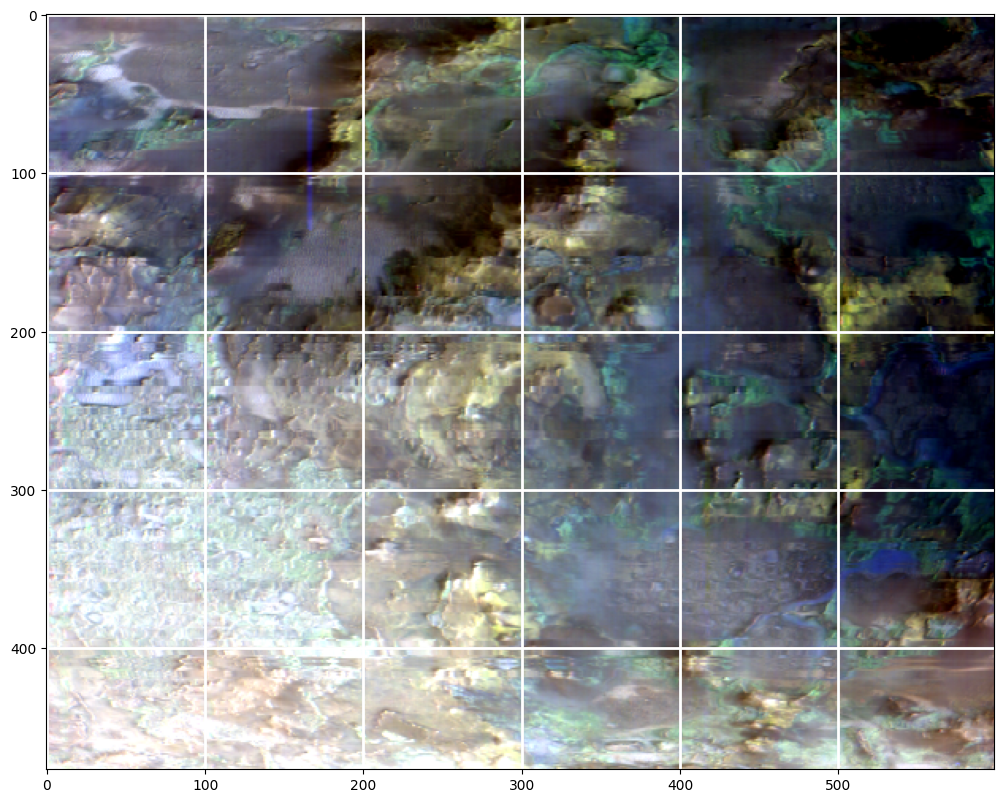

In [92]:
#set the band numbers to make the FCC
FCCBands=[13,78,233]
#create FCC stack
FCCStack=datacube[:,:,FCCBands]
#apply a 2% stretch
quantileValues=[]
for i in range(FCCStack.shape[2]):
    #get the quantiles 2% and 98%
    quantileValues=np.quantile(FCCStack[:,:,i],[0.02,0.98])
    #save band to a temporary variable
    temp=FCCStack[:,:,i]
    #set values outside the quantile range to the edge values
    temp[temp<quantileValues[0]]=quantileValues[0]
    temp[temp>quantileValues[1]]=quantileValues[1]
    #scale the values to the range
    temp=(temp-np.min(temp))/np.ptp(temp)
    #save the processed band
    FCCStack[:,:,i]=temp
del temp
#display the FCC
baseFigureSize=10
plt.figure(figsize=(baseFigureSize*FCCStack.shape[1]/FCCStack.shape[0],baseFigureSize),dpi=100)
plt.imshow(FCCStack)
plt.grid(visible=True,
         which='both',
         lw=2,
         color='white')#,
         #xdata=np.arange(0,datacube.shape[1]+datacube.shape[1]/10,datacube.shape[1]/10),
         #ydata=np.arange(0,datacube.shape[0]+datacube.shape[0]/10,datacube.shape[0]/10))
        

#set row and columns thresholds for zoomed image
rowLow=0
rowHigh=100
colLow=300
colHigh=400
#set the band numbers to make the FCC
FCCBands=[13,78,233]
#create FCC stack
FCCStack=datacube[rowLow:rowHigh,colLow:colHigh,FCCBands]
#apply a 2% stretch
quantileValues=[]
for i in range(FCCStack.shape[2]):
    #get the quantiles 2% and 98%
    quantileValues=np.quantile(FCCStack[:,:,i],[0.02,0.98])
    #save band to a temporary variable
    temp=FCCStack[:,:,i]
    #set values outside the quantile range to the edge values
    temp[temp<quantileValues[0]]=quantileValues[0]
    temp[temp>quantileValues[1]]=quantileValues[1]
    #scale the values to the range
    temp=(temp-np.min(temp))/np.ptp(temp)
    #save the processed band
    FCCStack[:,:,i]=temp
del temp
#display the FCC
baseFigureSize=100
plt.figure(figsize=(baseFigureSize*FCCStack.shape[1]/FCCStack.shape[0],baseFigureSize),dpi=100)
plt.imshow(FCCStack)
plt.grid(visible=True,
         which='both',
         lw=2,
         color='white')

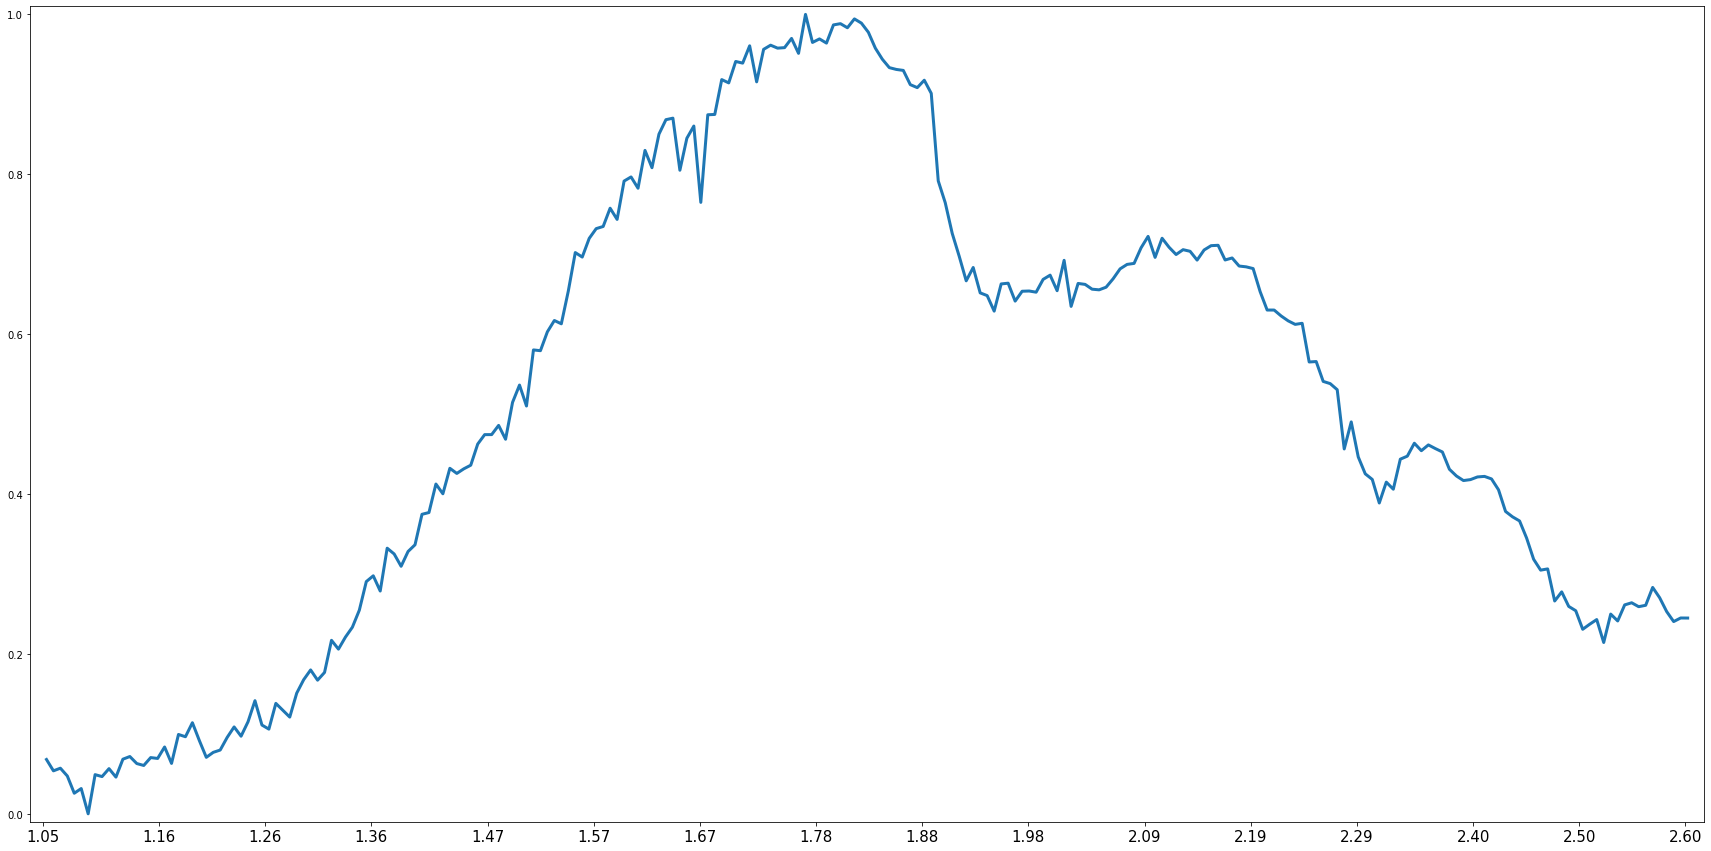

In [101]:
currentRowIndex=31
currentColIndex=300+82
absoluteRowIndex=currentRowIndex+rowLowerBound
absoluteColIndex=currentColIndex+colLowerBound

currentSpectra=datacube[currentRowIndex,currentColIndex,:]
normalizedSpectra=normalizeSpectra(currentSpectra)


plt.figure(figsize=(30,15))

wavelengthTicks=np.round(np.arange(wavelengthList[0],
                                   wavelengthList[-1]+(wavelengthList[-1]-wavelengthList[0])/15,
                                   (wavelengthList[-1]-wavelengthList[0])/15),2)

plt.xticks(wavelengthTicks,fontsize=15)

plt.plot(wavelengthList,normalizedSpectra,lw=3)
plt.margins(x=0.01,y=0.01)